# Classify individuals across age

In [256]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from toolz import partial, sliding_window
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
from math import floor, ceil

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "beh-individualization", tight_layout=False)

In [3]:
def load_long_df(version=5):
    usage_mtx = pd.read_parquet(
        f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/longtogeny_males_clean.parquet"
    )
    return usage_mtx

In [4]:
def get_train_test(df, random_state=0):
    test = df.groupby('mouse').sample(n=1, random_state=random_state)
    train = df.drop(test.index)
    return train, test

In [5]:
df = load_long_df(version=5)
df = df.query('age < 600')

keep_sylls = df.columns[df.median() > 0.005]
df = df[keep_sylls]

index = ['age', 'mouse', 'cage', 'uuid', 'subject_name', 'date']

index = ['binned_age'] + index
ages = df.index.get_level_values('age')
lbls, bins = pd.qcut(ages, 12, labels=False, retbins=True)

df['binned_age'] = lbls
df = df.reset_index().set_index(index)
binned_ages = df.groupby(['binned_age', 'mouse', 'cage']).mean()

bin_map = {k: np.mean(v) / 7 for k, v in enumerate(sliding_window(2, bins))}

In [6]:
df.reset_index().groupby('mouse')['age'].count()

mouse
01_01    64
01_02    58
01_03    52
01_04    61
02_01    66
02_02    64
02_03    53
02_04    52
03_01    65
03_02    64
03_03    40
03_04    58
04_01    64
04_02    61
04_03    54
04_04    57
Name: age, dtype: int64

In [349]:
ages = pd.qcut(df.reset_index()['age'], 18, labels=False)
avg_age = df.reset_index().groupby(ages)['age'].mean()

In [350]:
n_samples = 8
new_dataset = []
for mouse, _df in df.reset_index().groupby('mouse'):
    _df = _df.sort_values(by='age')
    for grp, _age in enumerate(avg_age.iloc[1:-1]):
        idx = np.argmin((_df['age'] - _age).abs())
        sample = _df.iloc[idx-ceil(n_samples/2):idx+floor(n_samples/2)].copy().reset_index(drop=True)
        sample['group'] = grp
        sample = sample.drop(columns=['cage', 'binned_age', 'subject_name'])
        if len(sample) < n_samples:
            continue
        new_dataset.append(sample)
new_dataset = pd.concat(new_dataset).set_index(['age', 'mouse', 'uuid', 'date'])

In [342]:
new_dataset.reset_index().groupby('group')['mouse'].nunique()

group
0     11
1     16
2     16
3     16
4     16
5     16
6     16
7     16
8     16
9     16
10    16
11    15
12    15
13    15
14    14
15    14
16    14
Name: mouse, dtype: int64

In [292]:
mdl = make_pipeline(
    PCA(n_components=20),
    StandardScaler(),
    LogisticRegression()
)

In [293]:
age_acc = {}
for bin, _df in tqdm(new_dataset.groupby("group", sort=False)):
    y = _df.index.get_level_values("mouse")
    acc = cross_val_score(
        mdl,
        _df.drop(columns=["group"]),
        y,
        cv=RepeatedStratifiedKFold(n_splits=n_samples // 2, n_repeats=10),
    )
    age_acc[bin] = acc

  0%|          | 0/30 [00:00<?, ?it/s]

In [294]:
age_acc = pd.DataFrame(age_acc)

In [295]:
to_plt = age_acc.melt(var_name='age', value_name='accuracy')
to_plt['age'] = to_plt['age'].map(dict(enumerate(avg_age.iloc[1:-1])))

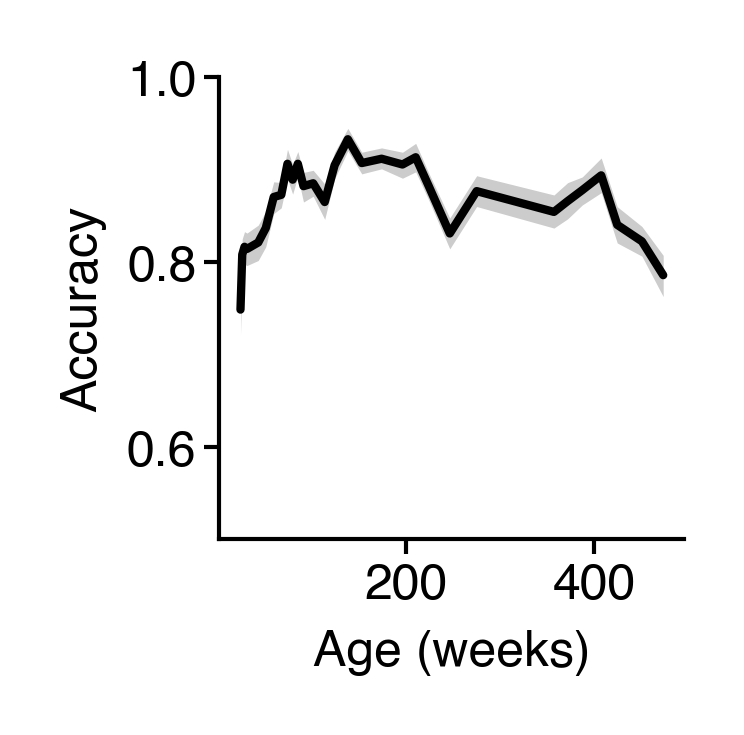

In [296]:
fig = figure(1, 1)
ax = sns.lineplot(data=to_plt, x='age', y='accuracy', color='k', err_kws=dict(lw=0), lw=1)
ax.set(ylabel="Accuracy", xlabel="Age (weeks)", ylim=[0.5, 1])
sns.despine()

In [282]:
np.random.seed(0)
shuff_age_acc = {}
n_shuffs = 10
for bin, _df in tqdm(new_dataset.groupby("group", sort=False)):
    y = _df.index.get_level_values("mouse").to_numpy()
    accs = []
    for i in range(n_shuffs):
        np.random.shuffle(y)
        acc = cross_val_score(
            mdl,
            _df.drop(columns=["group"]),
            y,
            cv=StratifiedKFold(n_splits=n_samples // 2),
        )
        accs.extend(acc)
    shuff_age_acc[bin] = accs

  0%|          | 0/14 [00:00<?, ?it/s]

In [283]:
shuff_age_acc = pd.DataFrame(shuff_age_acc)

In [284]:
shuff_plt = shuff_age_acc.melt(var_name='age', value_name='accuracy')
shuff_plt['age'] = shuff_plt['age'].map(dict(enumerate(avg_age.iloc[1:-1])))

In [285]:
shuff_avg_acc = shuff_plt.groupby('age')['accuracy'].mean()

In [286]:
tmp_plt = to_plt.set_index('age')
tmp_plt = tmp_plt['accuracy'] / shuff_avg_acc.reindex(tmp_plt.index)

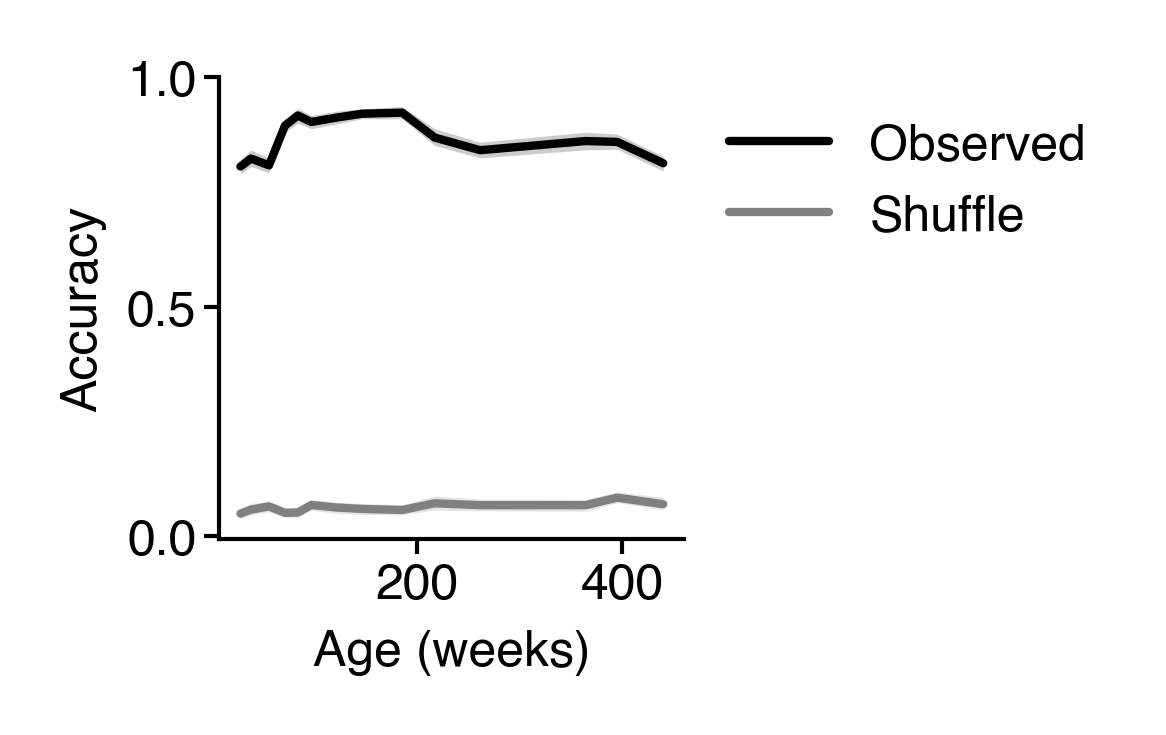

In [287]:
fig = figure(1, 1)
ax = sns.lineplot(data=to_plt, x='age', y='accuracy', color='k', err_kws=dict(lw=0), lw=1, label='Observed')
ax = sns.lineplot(data=shuff_plt, x='age', y='accuracy', color='gray', err_kws=dict(lw=0), lw=1, label='Shuffle', ax=ax)
ax.set(ylabel="Accuracy", xlabel="Age (weeks)", ylim=[None, 1])
legend(ax)
sns.despine()

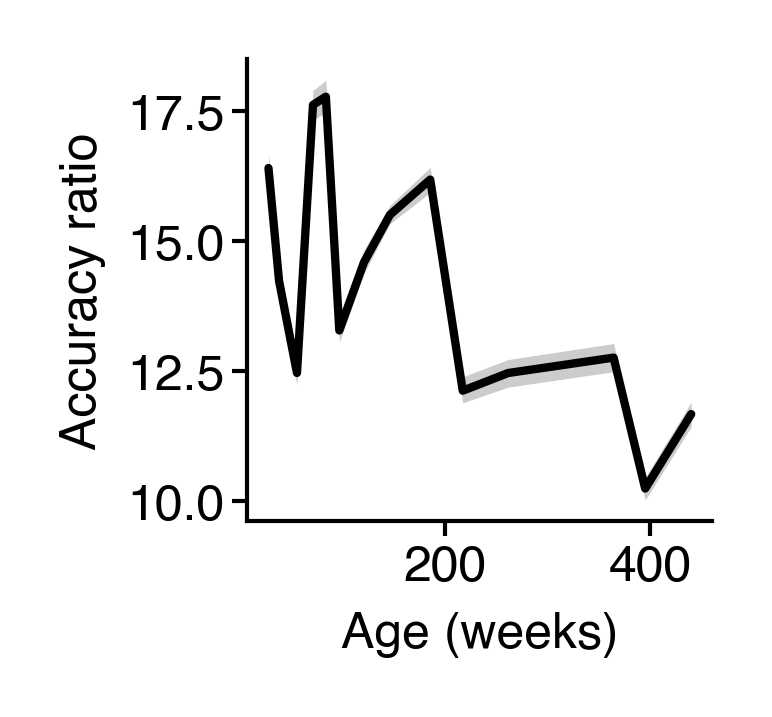

In [288]:
fig = figure(1, 1)
ax = sns.lineplot(data=pd.DataFrame(tmp_plt).reset_index(), x='age', y='accuracy', color='k', err_kws=dict(lw=0), lw=1)
ax.set(ylabel="Accuracy ratio", xlabel="Age (weeks)")
sns.despine()

## Find optimal model parameters

In [313]:
cs = {}
for c in tqdm(range(1, df.shape[1] - 1)):
    mdl = make_pipeline(
        PCA(n_components=c),
        StandardScaler(),
        LogisticRegression()
    )

    age_acc = {}
    for bin, _df in new_dataset.groupby("group", sort=False):
        y = _df.index.get_level_values("mouse")
        acc = cross_val_score(
            mdl,
            _df.drop(columns=["group"]),
            y,
            cv=RepeatedStratifiedKFold(n_splits=n_samples // 2, n_repeats=5),
        )
        age_acc[bin] = acc
    age_acc = pd.DataFrame(age_acc)
    cs[c] = age_acc.mean()

  0%|          | 0/42 [00:00<?, ?it/s]

In [314]:
cs = pd.DataFrame(cs)

In [315]:
cs.max().sort_values()

2     0.515625
1     0.537500
3     0.612500
4     0.703125
6     0.781250
5     0.790625
7     0.800000
8     0.817187
9     0.825000
10    0.864062
12    0.871875
11    0.873437
13    0.887500
14    0.893750
15    0.906250
16    0.909375
41    0.914062
17    0.918750
19    0.918750
40    0.921875
39    0.921875
37    0.925000
21    0.926562
26    0.926667
22    0.928125
42    0.929688
27    0.929688
23    0.929688
25    0.931250
18    0.931250
35    0.932813
28    0.935937
30    0.935937
31    0.935937
38    0.937500
24    0.937500
32    0.937500
29    0.939063
34    0.942187
36    0.942187
20    0.943750
33    0.945312
dtype: float64

In [316]:
age_acc = pd.DataFrame(age_acc)

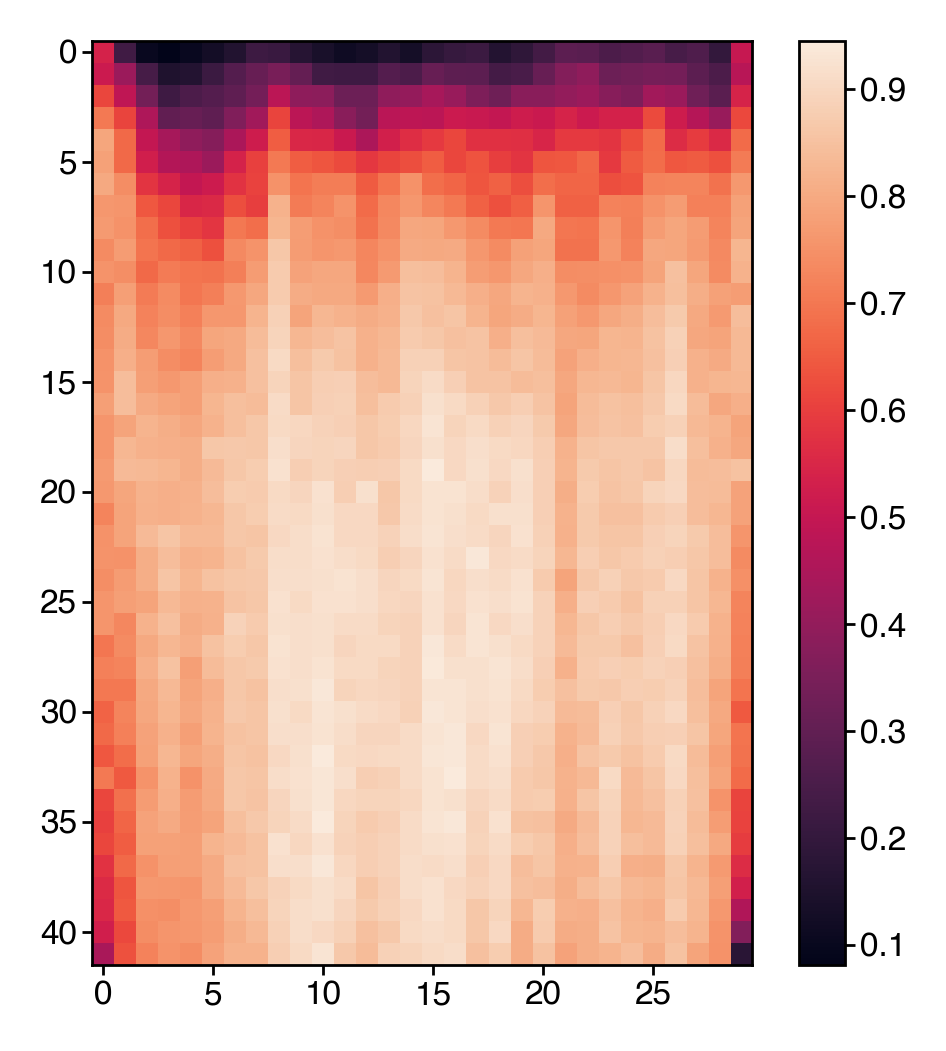

In [317]:
plt.imshow(cs.T)
plt.colorbar()

In [327]:
cs = {}
mdl = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)
for c in tqdm(range(1, df.shape[1] - 1)):
    data = PCA(n_components=c).fit_transform(new_dataset.iloc[:, :-1])
    data = pd.DataFrame(data, index=new_dataset.index)
    data['group'] = new_dataset['group']
    age_acc = {}
    for bin, _df in data.groupby("group", sort=False):
        y = _df.index.get_level_values("mouse")
        acc = cross_val_score(
            mdl,
            _df.drop(columns=["group"]),
            y,
            cv=RepeatedStratifiedKFold(n_splits=n_samples // 2, n_repeats=5),
        )
        age_acc[bin] = acc
    age_acc = pd.DataFrame(age_acc)
    cs[c] = age_acc.mean()

  0%|          | 0/42 [00:00<?, ?it/s]

In [328]:
cs = pd.DataFrame(cs)

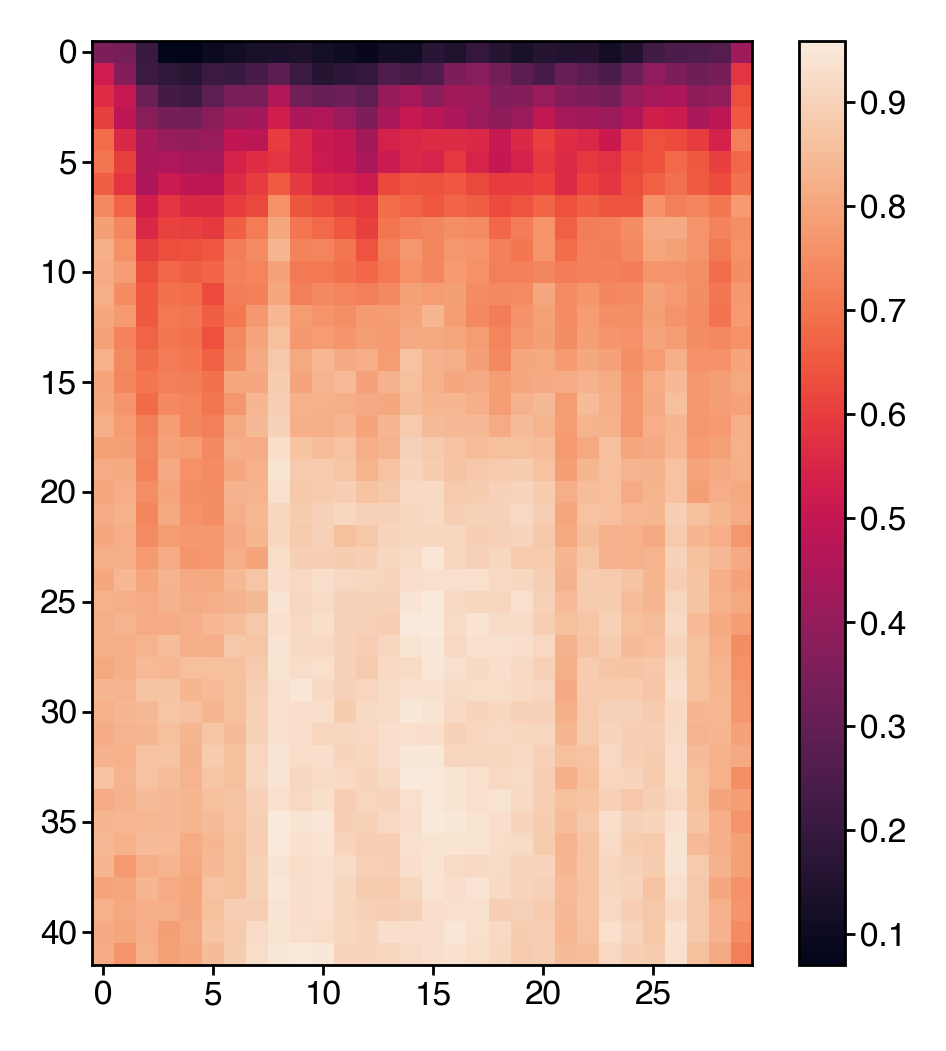

In [329]:
plt.imshow(cs.T)
plt.colorbar()

In [330]:
cs.max().sort_values(ascending=False)

27    0.959375
42    0.957812
34    0.957812
26    0.957812
36    0.956250
37    0.953125
35    0.953125
28    0.951562
33    0.950000
31    0.950000
39    0.948438
24    0.948438
30    0.948438
41    0.948438
29    0.946875
40    0.945312
38    0.945312
20    0.939063
32    0.935937
25    0.934375
21    0.932813
19    0.925000
22    0.918750
23    0.914062
18    0.903125
17    0.890625
16    0.889062
15    0.876563
14    0.860938
13    0.839063
10    0.835938
12    0.818750
11    0.815625
9     0.812500
8     0.778571
5     0.721429
6     0.703125
7     0.694643
4     0.650000
3     0.632143
2     0.582143
1     0.417857
dtype: float64

In [360]:
mdl = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

age_acc = {}
for bin, _df in new_dataset.groupby("group", sort=False):
    y = _df.index.get_level_values("mouse")
    acc = cross_val_score(
        mdl,
        _df.drop(columns=["group"]),
        y,
        cv=RepeatedStratifiedKFold(n_splits=n_samples // 2, n_repeats=15),
    )
    age_acc[bin] = acc
age_acc = pd.DataFrame(age_acc)

In [361]:
to_plt = age_acc.iloc[:, 1:-1].melt(var_name='age', value_name='accuracy')
to_plt['age'] = to_plt['age'].map(dict(enumerate(avg_age.iloc[1:-1]))) / 7

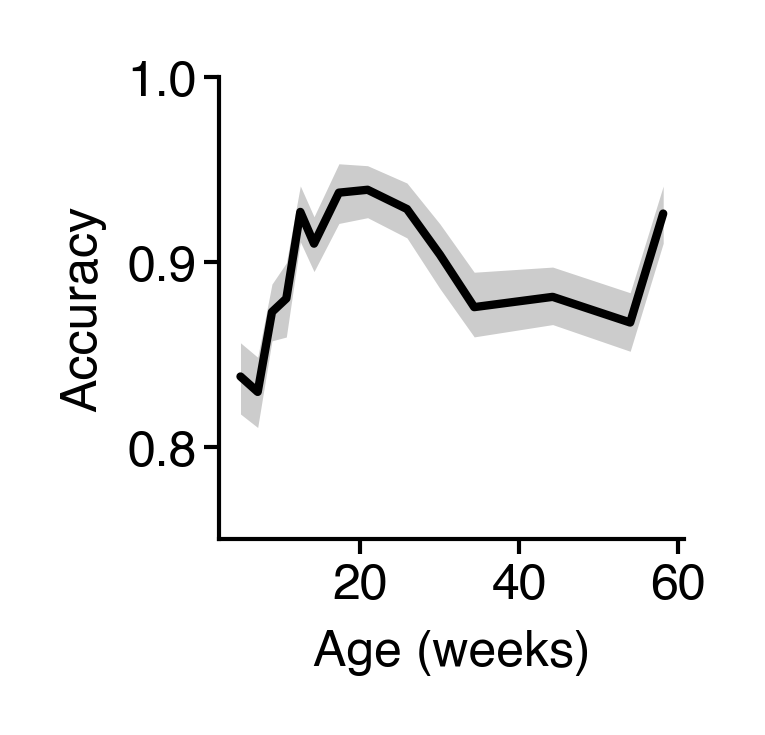

In [373]:
fig = figure(1, 1)
ax = sns.lineplot(
    data=to_plt,
    x="age",
    y="accuracy",
    color="k",
    err_kws=dict(lw=0),
    lw=1,
    errorbar=("ci", 99),
)
ax.set(ylabel="Accuracy", xlabel="Age (weeks)", ylim=[0.75, 1])
sns.despine()
saver(fig, "mouse-decoder-across-age");

In [363]:
np.random.seed(0)
shuff_age_acc = {}
n_shuffs = 10
for bin, _df in tqdm(new_dataset.groupby("group", sort=False)):
    y = _df.index.get_level_values("mouse").to_numpy()
    accs = []
    for i in range(n_shuffs):
        np.random.shuffle(y)
        acc = cross_val_score(
            mdl,
            _df.drop(columns=["group"]),
            y,
            cv=StratifiedKFold(n_splits=n_samples // 2),
        )
        accs.extend(acc)
    shuff_age_acc[bin] = accs

  0%|          | 0/16 [00:00<?, ?it/s]

In [371]:
shuff_age_acc = pd.DataFrame(shuff_age_acc)
shuff_plt = shuff_age_acc.iloc[:, 1:-1].melt(var_name='age', value_name='accuracy')
shuff_plt['age'] = shuff_plt['age'].map(dict(enumerate(avg_age.iloc[1:-1]))) / 7

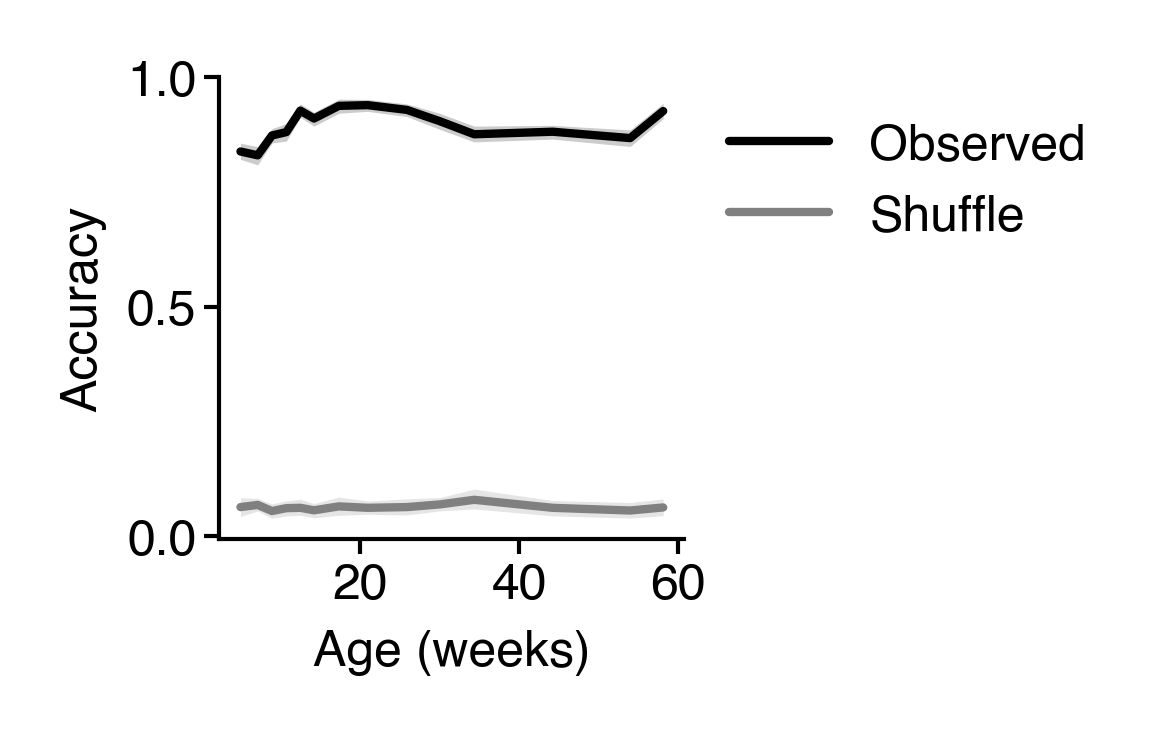

In [372]:
fig = figure(1, 1)
ax = sns.lineplot(data=to_plt, x='age', y='accuracy', color='k', err_kws=dict(lw=0), lw=1, label='Observed', errorbar=('ci', 99))
ax = sns.lineplot(data=shuff_plt, x='age', y='accuracy', color='gray', err_kws=dict(lw=0), lw=1, label='Shuffle', ax=ax, errorbar=('ci', 99))
ax.set(ylabel="Accuracy", xlabel="Age (weeks)", ylim=[None, 1])
legend(ax)
sns.despine()
saver(fig, "mouse-decoder-across-age-plus-shuffle");